## Creating the dataset and training the model

In [1]:
# import the packages
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import torch 
import torchaudio
from torch.utils.data import DataLoader, random_split

import IPython.display as ipd
import matplotlib.pyplot as plt
import seaborn as sns


from utils import *
from model import BirdAudioClassifierModel, ModelTrainer, ModelTester

### Checking if cuda is available

In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA RTX A500 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


### Creating a Custom Dataset

In [3]:
#load metadata df 
current_dir = os.getcwd() 
file_name = "Dataset\\metadata.csv"
file_path = os.path.join(current_dir, file_name) 
df_metadata = pd.read_csv(file_path)
display(df_metadata)

# #load the metadata for the filtered audio 
# file_name = "Dataset\\filtered_metadata.csv"
# file_path = os.path.join(current_dir, file_name) 
# df_filtered_metadata = pd.read_csv(file_path)
# display(df_filtered_metadata)
# #combine the two to have more a training set with mixed data 
# df_metadata = pd.concat([df_metadata, df_filtered_metadata], axis=0)
# display(df_metadata)


,file_id,original_file_id,english_cname,relative_path,class_id
0,1,101371,Long-tailed Tit,Dataset\preprocessed_songs\1.flac,0
1,2,101371,Long-tailed Tit,Dataset\preprocessed_songs\2.flac,0
2,3,101371,Long-tailed Tit,Dataset\preprocessed_songs\3.flac,0
3,4,101371,Long-tailed Tit,Dataset\preprocessed_songs\4.flac,0
4,5,101371,Long-tailed Tit,Dataset\preprocessed_songs\5.flac,0
...,...,...,...,...,...
3543,3544,99937,Eurasian Nuthatch,Dataset\preprocessed_songs\3544.flac,75
3544,3545,99937,Eurasian Nuthatch,Dataset\preprocessed_songs\3545.flac,75
3545,3546,99937,Eurasian Nuthatch,Dataset\preprocessed_songs\3546.flac,75
3546,3547,99937,Eurasian Nuthatch,Dataset\preprocessed_songs\3547.flac,75


In [4]:
##splitting the dataset with uniform class_id distribution (ensure that the each of the datasets has an appropriate amout of example from each class)

#split the data into training and temp sets(80% training, 20% temp)
df_train, df_temp = train_test_split(df_metadata, test_size=0.2, stratify=df_metadata["class_id"], random_state=42)
# split the temp set into testing and validation sets (50% each)
df_test, df_val = train_test_split(df_temp, test_size=0.5, stratify=df_temp["class_id"], random_state=42)

#resetting the indices to avoid indexing errors when loading data using the custom AudioDataSet 
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

# Print the sizes of the splits
print("Training set size:", len(df_train))
print("Testing set size:", len(df_test))
print("Validation set size:", len(df_val))

# You can access the class distribution in each set using value_counts
print("Training set class distribution:\n", df_train["class_id"].value_counts())
print("Testing set class distribution:\n", df_test["class_id"].value_counts())
print("Validation set class distribution:\n", df_val["class_id"].value_counts())

Training set size: 2838
Testing set size: 355
Validation set size: 355
Training set class distribution:
 class_id
31    120
32     93
33     90
69     85
22     81
     ... 
3      11
48     10
20      9
19      8
81      8
Name: count, Length: 88, dtype: int64
Testing set class distribution:
 class_id
31    15
33    12
32    12
22    11
69    10
      ..
75     1
54     1
55     1
81     1
42     1
Name: count, Length: 88, dtype: int64
Validation set class distribution:
 class_id
31    15
32    12
33    11
69    11
7     10
      ..
77     2
19     1
48     1
20     1
81     1
Name: count, Length: 88, dtype: int64


In [5]:
#create the datasets and data loaders 
#create the training, validaiton and testing datasets 
train_dataset = AudioDataSet(df_metadata=df_train, base_dir=current_dir)
val_dataset = AudioDataSet(df_metadata=df_val, base_dir=current_dir)
test_dataset = AudioDataSet(df_metadata=df_test, base_dir=current_dir)

#create the training, validation and test data loaders  (https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True) 
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True) 

#print the lengths of each set
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 2838
Validation set size: 355
Test set size: 355


Shape of spectrograms: torch.Size([16, 1, 401, 552]), Class ids: tensor([21, 39, 31, 15, 31, 33, 73, 77, 47, 32, 10, 31, 18, 28, 33,  9])


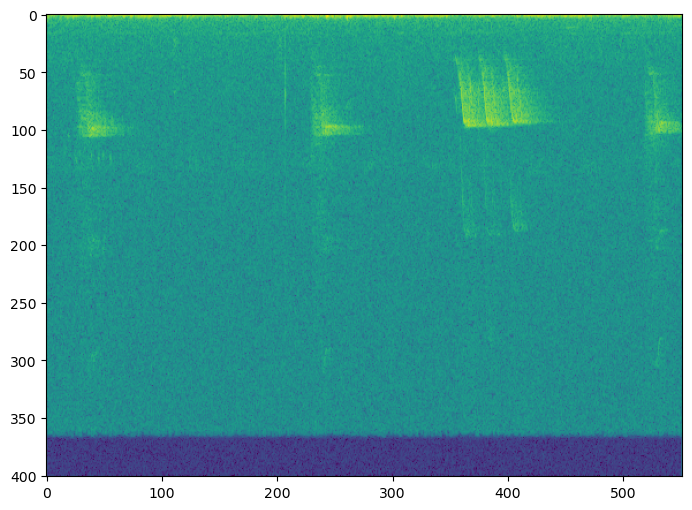

In [6]:
#test data loaders 
spectrograms, class_id = next(iter(train_dataloader)) 
print(f"Shape of spectrograms: {spectrograms.size()}, Class ids: {class_id}")
plt.figure(figsize=(10, 6))
plt.imshow(spectrograms[0,0,:,:].numpy())

### Training the model

In [16]:
#train model
model = BirdAudioClassifierModel(num_classes=88)
#load already trained model
model.load_state_dict(torch.load('Models\model2.pth'))
#create trainer 
model_trainer = ModelTrainer(model=model, learning_rate=0.0001)
num_epochs = 8 #instead of 15 to avoid overfitting

train_losses, val_losses = model_trainer.train(num_epochs=num_epochs, 
                                                train_dataloader=train_dataloader, 
                                                test_dataloader=val_dataloader)

print(train_losses) 
print(val_losses)

#saving the trained model
model_trainer.save_model('Models\model3.pth')



Epoch 1
-------------------------------
loss: 5.913611  [    0/11135]
loss: 2.356046  [  400/11135]
loss: 1.845036  [  800/11135]
loss: 1.114484  [ 1200/11135]
loss: 1.593587  [ 1600/11135]
loss: 1.952777  [ 2000/11135]
loss: 1.276036  [ 2400/11135]
loss: 1.372933  [ 2800/11135]
loss: 1.145210  [ 3200/11135]
loss: 0.548679  [ 3600/11135]
loss: 0.503316  [ 4000/11135]
loss: 2.064472  [ 4400/11135]
loss: 0.346876  [ 4800/11135]
loss: 2.274129  [ 5200/11135]
loss: 0.755066  [ 5600/11135]
loss: 1.226601  [ 6000/11135]
loss: 0.906750  [ 6400/11135]
loss: 0.649078  [ 6800/11135]
loss: 1.199039  [ 7200/11135]
loss: 1.254431  [ 7600/11135]
loss: 0.419966  [ 8000/11135]
loss: 1.269442  [ 8400/11135]
loss: 0.801463  [ 8800/11135]
loss: 0.595825  [ 9200/11135]
loss: 0.557950  [ 9600/11135]
loss: 0.700592  [10000/11135]
loss: 0.836364  [10400/11135]
loss: 1.031587  [10800/11135]

Test Error:
acc: 82.2%, avg loss: 0.046498

Epoch 2
-------------------------------
loss: 0.540218  [    0/11135]
loss:

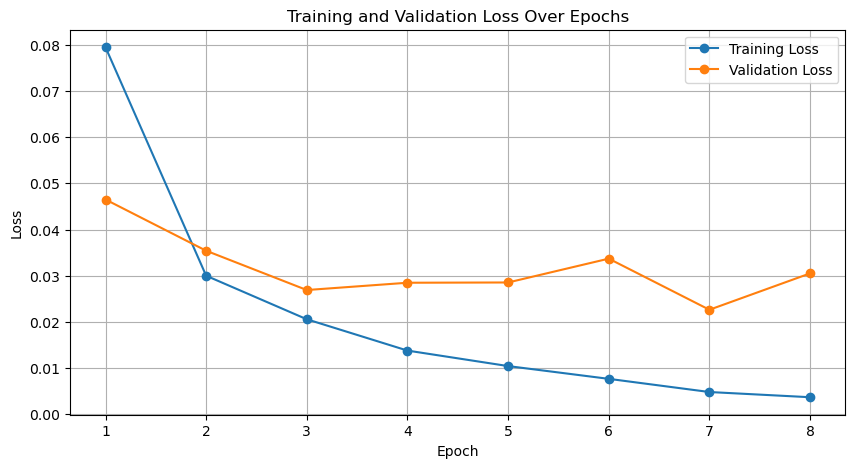

In [17]:
#plot the loss training loss over the validation loss 
#create epoch list
epochs = [i+1 for i in range(num_epochs)]

# Plotting the training and test losses
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')

plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
# Save the plot as an image file
plt.savefig('Models\loss_plot_model3.png')
plt.show()

### Model Evaluation 
Evaluating model performance on test dataset

In [7]:
#Create the model
num_bird_classes = 88
model = BirdAudioClassifierModel(num_classes=num_bird_classes)
#load the trained model 
model.load_state_dict(torch.load('Models\model2.pth'))

<All keys matched successfully>

In [8]:
modelTester = ModelTester(model=model, test_dataloader=test_dataloader)

In [9]:
# print accuracy, overall performance
print(f"Accuracy: {round(modelTester.get_accuracy()*100, 2)}%")
#print precision, accuracy of the positive predictions made by the classifier.
print(f"Precision: {round(modelTester.get_precision()*100, 2)}%")
#print recall, rate of correct positive predictions over all positives
print(f"Recall: {round(modelTester.get_recall()*100, 2)}%")
#print F1 score, The harmonic mean of precision and recall
print(f"F1 score: {round(modelTester.get_F1_score()*100, 2)}%")

Accuracy: 83.66%
Rrecision: 83.66%
Recall: 83.66%
F1 score: 83.66%


In [10]:
confusion_matrix = modelTester.get_confusion_matrix()
print(f"confusion matrix: {confusion_matrix}")

confusion matrix: [[0 0 0 ... 0 0 0]
 [0 3 0 ... 0 0 0]
 [0 0 3 ... 0 0 0]
 ...
 [0 0 0 ... 3 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 3]]


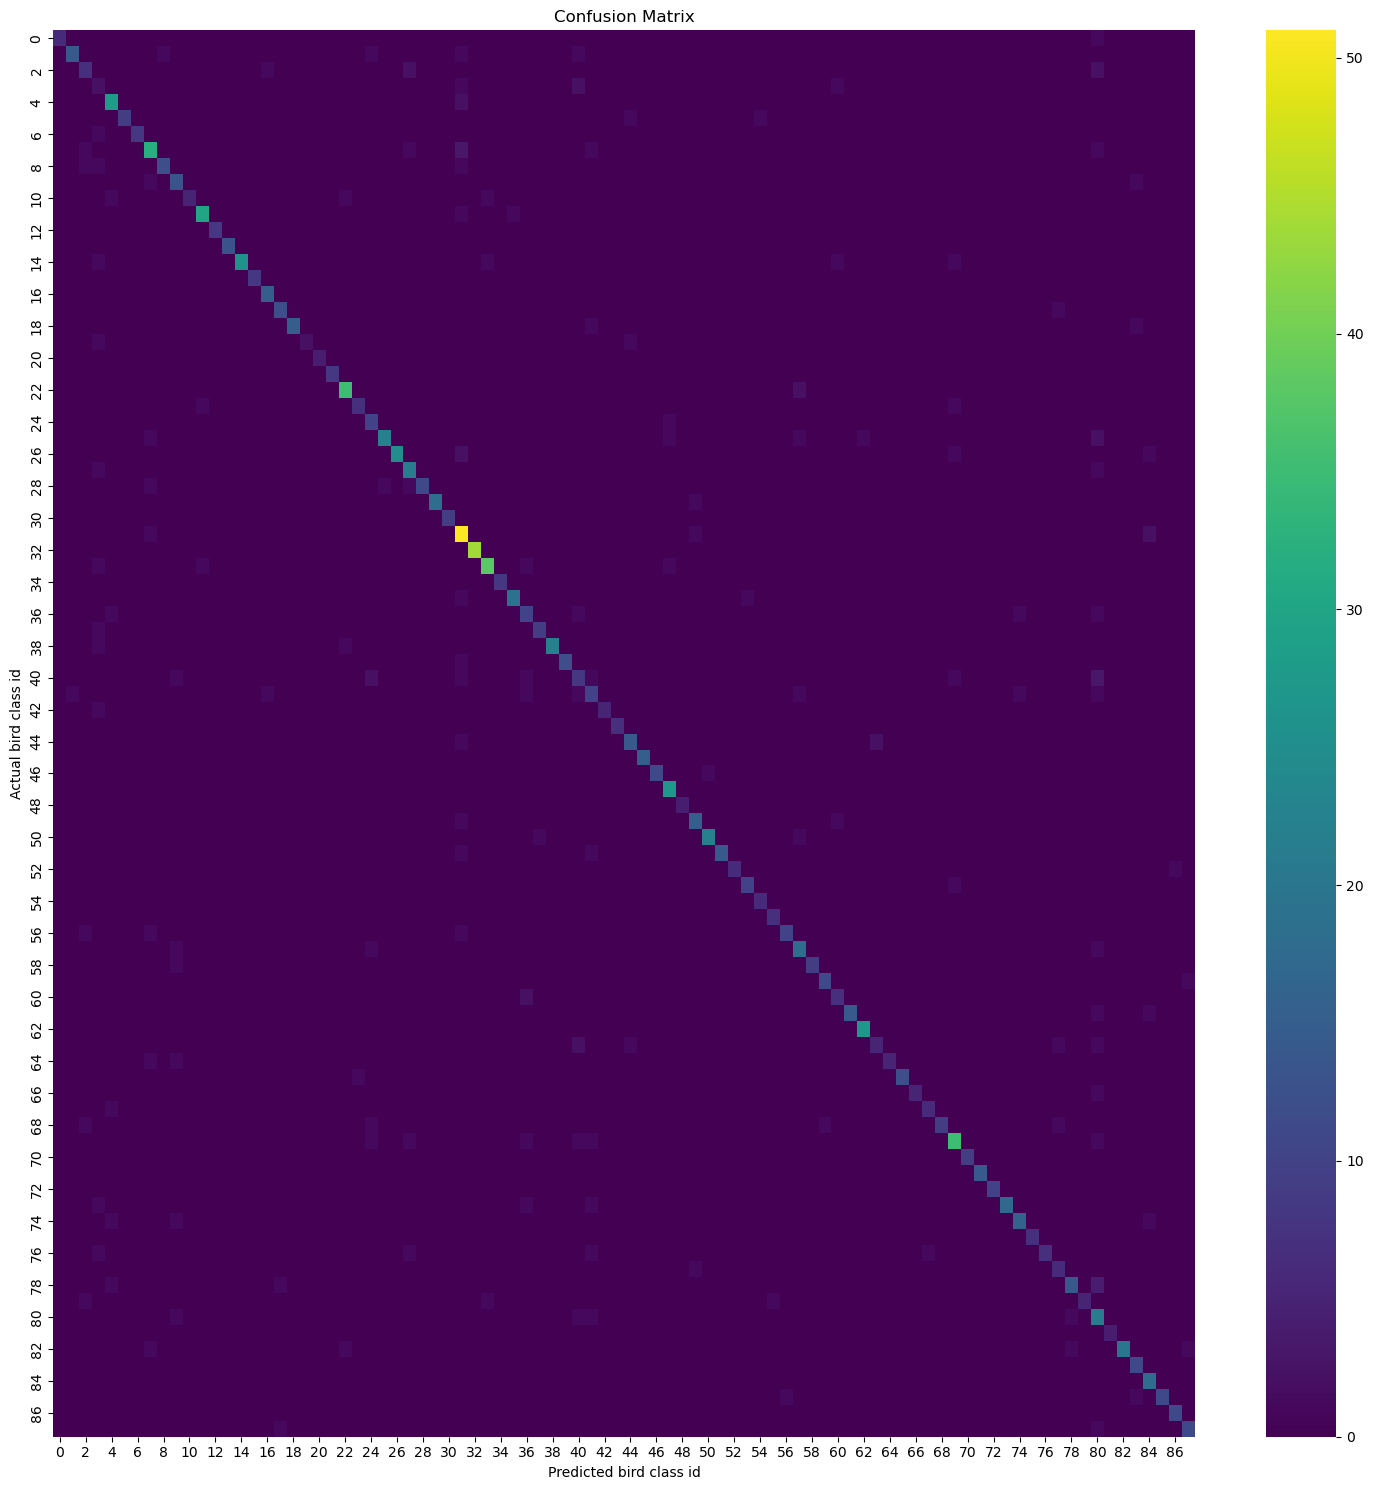

In [22]:
#plot the confusion matrix
plt.figure(figsize=(15, 15))
sns.heatmap(confusion_matrix, cmap="viridis", cbar=True)
plt.xlabel("Predicted bird class id")
plt.ylabel("Actual bird class id")
plt.title("Confusion Matrix")
# Add tight layout
plt.tight_layout()
# plt.savefig('Models\confusion_matrix_model_3.png')
plt.show()

In [23]:
#print the classes for which the classifier does not perform well (threshold can be triggered when to few number of samples)
for i, row in enumerate(modelTester.get_confusion_matrix()): 
    true_postivies = row[i]
    actual_positives = sum(row)
    false_negative = actual_positives - true_postivies

    if true_postivies < actual_positives * 0.7: 
        print(f"Class_id: {i}, true positive: {row[i]}, false negative: {false_negative}, total postivies: {actual_positives}")

Class_id: 2, true positive: 7, false negative: 5, total postivies: 12
Class_id: 3, true positive: 2, false negative: 4, total postivies: 6
Class_id: 10, true positive: 5, false negative: 3, total postivies: 8
Class_id: 19, true positive: 2, false negative: 2, total postivies: 4
Class_id: 40, true positive: 8, false negative: 10, total postivies: 18
Class_id: 41, true positive: 10, false negative: 7, total postivies: 17
Class_id: 63, true positive: 5, false negative: 5, total postivies: 10
Class_id: 68, true positive: 9, false negative: 4, total postivies: 13
Class_id: 76, true positive: 7, false negative: 4, total postivies: 11
Class_id: 79, true positive: 5, false negative: 3, total postivies: 8
